# Gotta Scrape 'em All!: Analyzing Pokémon Stats Throughout The Generations
#### By: Lucas Barton

## Step 0: Welcome!

This website is meant for beginner Pokémon players to learn the strength of Pokémon from each Pokémon generation, and I will help their understanding by analyzing the difference in **base stat totals** across types, generations, and regular/legendary Pokémon. I am going to be scraping data, putting it in a pandas DataFrame, and using said frame to draw conclusions, make graphs/charts, making regressions, and perform hypothesis tests against each category I make, estimating how strong team of 6 random Pokémon can be. There are other things to consider when it comes to Pokémon battles, such as abilities, movesets, items, and a whole host of other things, but in terms of raw power, this project is set out to study just that.

Before you begin reading, I want to define what a **base stat total** is. In Pokémon games, each monster has 6 different statistics: HP, Attack, Defense, Special Attack, Special Defense, and Speed, each ranging from 0-255, although no statistic is ever 0. The base stat total is the **total sum of the statistics of a Pokémon**. For example, Bulbasaur has base stats of:
 - HP: 45
 - Attack: 49
 - Defense: 49
 - Special Attack: 65
 - Special Defense: 65
 - Speed: 45

making its base stat total 318.

## A quick precursor:
If you know a thing or two about Pokémon, you might know that starting in Generation 6, a handful of Pokémon got some stat inreases. The buffs were minor, but they would bring about different data if these Pokémon were considered pre- and post-buff. However, I'll only be dealing with the post-buff data. It is reasonably expected that because the older games and consoles are not easily acquireable and emulating games without ownership is illegal, anybody playing a Pokémon game is highly expected to be playing a modern game on a modern console, which has these stat changes. Many of the generations are available on the modern consoles with the modern statistics, with the only exceptions being Generations 2 and 5. These two generations are currently only available on the DS, and because the DS is an older console and the respective games can cost upwards of $100, I can reasonably exclude the pre-change data.

## Step 1: Get the data
My data comes from [this Kaggle set](https://www.kaggle.com/mariotormo/complete-pokemon-dataset-updated-090420/discussion/195347), which is pretty packed. It has 1045 Pokémon because it includes the different forms, such as all the Arceus types, Darmanitan and Darmanitan Zen, all the megas, etc. For simplicity, I will be considering every one of these Pokémon, because it is entirely possible to include any assortment of 6 Pokémon on your team.

In addition, I also referenced popular Pokémon sites, such as [Bulbapedia](https://bulbapedia.bulbagarden.net/wiki/Main_Page), [Serebii](https://www.serebii.net/index2.shtml), and conveniently named [Pokémon Database](https://pokemondb.net), for confirmations about things like Pokémon forms and stat totals.

The columns I'll be keeping are:
1. name: The English name of the Pokémon
2. type_1: The primary type of the Pokémon
3. type_2: The secondary type of the Pokémon. If the Pokémon does not have one, then it is NaN
4. status: The category of the Pokémon. Either Regular, Sub Legendary (legendaries allowed in battle), Legendary, and Mythical (both not allowed in battle)
5. total_points: The base stat total of the Pokémon
6. generation: The generation of the Pokémon

In [274]:
import pandas as pd
import numpy as np
import scipy.stats as stat
import seaborn as sns
from sklearn import linear_model

dayta = pd.read_csv('pokedex_(Update_11.20).csv')
columns = ['name', 'type_1', 'type_2', 'status', 'total_points', 'generation']
data = dayta[columns]
data

,name,type_1,type_2,status,total_points,generation
0,Bulbasaur,Grass,Poison,Normal,318,1
1,Ivysaur,Grass,Poison,Normal,405,1
2,Venusaur,Grass,Poison,Normal,525,1
3,Mega Venusaur,Grass,Poison,Normal,625,1
4,Charmander,Fire,NaN,Normal,309,1
...,...,...,...,...,...,...
1040,Glastrier,Ice,NaN,Sub Legendary,580,8
1041,Spectrier,Ghost,NaN,Sub Legendary,580,8
1042,Calyrex,Psychic,Grass,Legendary,500,8
1043,Calyrex Ice Rider,Psychic,Ice,Legendary,680,8


## Step 2: Move the data
I'm going to be running regressions and tests between generations (only Pokémon from a certain generation), between types, cumulative generations (all Pokémon available in that generation, which is just Pokémon in generations 1 through the one I'm analyzing), and between classifications (legendary, mythical, pseudo-legendary, and regular), so I need to get frames for all of them just to make my life a little easier.

In [11]:
gen_arr = [] #Gens 1-8 as indeces 0-7

#Grass = 0, fire = 1, water = 2, bug = 3, normal = 4, dark = 5, poison = 6, electric = 7, ground = 8, 
#ice = 9, fairy = 10, steel = 11, fighting = 12, psychic = 13, rock = 14, ghost = 15, dragon = 16, flying = 17
type_arr = []
class_arr = [] #Normal, Sub Legendary, Legendary, and Mythical as indeces 0-3
cu_arr = [] #Cumulative gens 1-8 as indeces 0-7



#All mega and primal evolutions are unique to gen 6, and Alolan and Galarian forms are unique to their own gens
for index, row in data.iterrows():
    if 'Mega' in row['name'] or 'Primal' in row['name']:
        data.at[index, 'generation'] = 6
    if 'Alolan' in row['name']:
        data.at[index, 'generation'] = 7
    if 'Galarian' in row['name']:
        data.at[index, 'generation'] = 8

statuses = data['status'].unique()
types = data['type_1'].unique()

for i in range(1,9):
    tempframe = data[data['generation'] <= i].copy()
    cu_arr.append(tempframe)
    subframe = data[data['generation'] == i]
    gen_arr.append(subframe)
    
for color in types:
    tempframe1 = data[(data['type_1'] == color) | (data['type_2'] == color)].copy()
    
    #Since I will be counting Pokémon twice if they have two different types, once for their first type, once for their second, I need a type label for the specific frame I'm working with
    tempframe1['type'] = [color] * len(tempframe1)
    type_arr.append(tempframe1)
    
for status in statuses:
    tempframe = data[data['status'] == status]
    class_arr.append(tempframe)

## Step 3: Looking at the data

We'll just be looking at graphs of each data frame and drawing conclusions from those. Later on, I will be doing a more in-depth analysis of all of the data I have, from linear regression to taking samples and making a learning model.

### Step 3.A: Unique Generations

The first thing I want to do is compare the generational stat differences and see if Pokémon change drastically in stats throughout the generations, as things like Mega Evolutions and Dynamaxing were introduced and may have skewed the power scaling of Pokémon from each generation. I don't expect much difference between the generations because no Pokémon receive stat changes between generations, allowing Pokémon from all generations to be used in any concurrent generation.

<AxesSubplot:xlabel='generation', ylabel='total_points'>

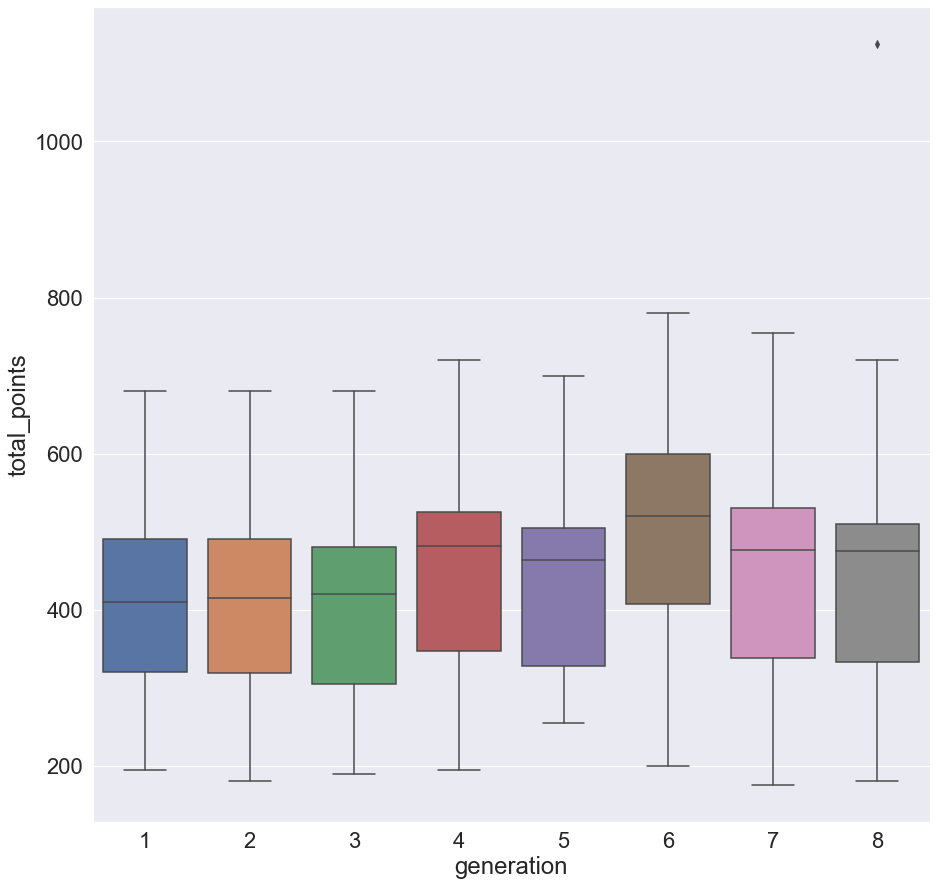

In [12]:
plt.figure(figsize=(15,15))
sns.set(font_scale=2)
ax = sns.boxplot(x='generation', y='total_points', data=data)
ax

Wow, there is a significant difference in the base stat total of generation 6 compared to the other generations! This is because of the significant number of Mega Evolutions introduced in generation 6, and I am including their base stat totals, because you could have 6 Mega Evolved Pokémon on your team (although that requires cheating). In addition to Mega Evolutions, there are Dynamax Pokémon introduced in generation 8, and that sole outlier for generation 8 is Eternatus Eternamax Forme, which is obviously incredibly powerful. But because Dynamaxing only lasts 3 turns, and you can actually only have 1 Mega Evolved Pokémon on your team per battle, what does this data look like when we don't consider Mega Evolutions or Dynamaxed Pokémon?

<AxesSubplot:xlabel='generation', ylabel='total_points'>

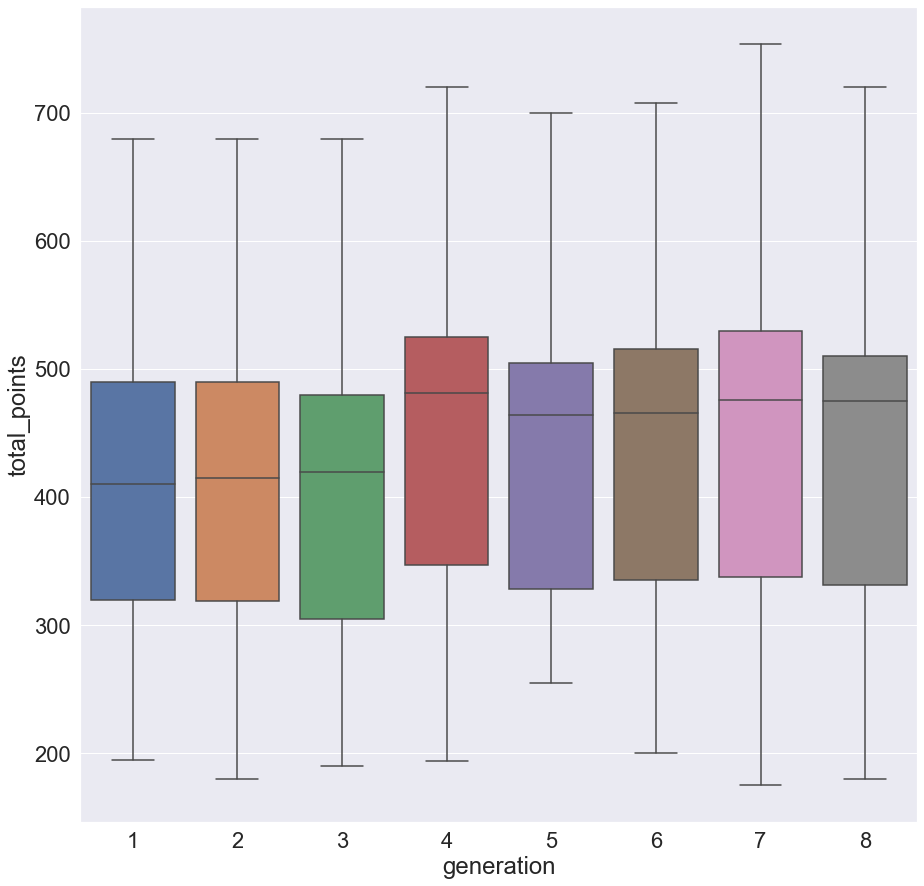

In [13]:
no_megas = data.copy()
for idx, row in no_megas.iterrows():
    #Eternamax is the same as Dynamax, only it's exclusive to Eternatus, and Primal is the same as Mega, only it's exclusive to Groudon, Kyogre, and Rayquaza
    if 'Mega' in str(row['name']) or 'Dynamax' in row['name'] or 'Eternamax' in row['name'] or 'Primal' in row['name']:
        no_megas = no_megas.drop(idx)

        
plt.figure(figsize=(15,15))
sns.set(font_scale=2)
ax = sns.boxplot(x='generation', y='total_points', data=no_megas)
ax

That looks more even, doesn't it? We can see that the earlier generations were weaker compared to the newer ones, since generations 1-3 had an average stat total around 400, while generations 4-8 have theirs hovering around 450. Even with the generation 6 buff that went to mostly earlier generational Pokémon, it looks like the earlier Pokémon would still struggle to hold their own against the more recent Pokémon.

In [14]:
for i in range(0,len(gen_arr)):
    print('Average base stat total for generation {}: {}'.format(i+1, no_megas[no_megas['generation'] == i+1]['total_points'].mean()))

Average base stat total for generation 1: 407.9673202614379
Average base stat total for generation 2: 405.989898989899
Average base stat total for generation 3: 408.2482269503546
Average base stat total for generation 4: 451.9310344827586
Average base stat total for generation 5: 434.8969696969697
Average base stat total for generation 6: 439.48809523809524
Average base stat total for generation 7: 449.1794871794872
Average base stat total for generation 8: 444.52542372881356


### Step 3.B: Combined Generations

Obviously in each generation, you aren't limited to just the Pokémon introduced in that generation, and I will be representing the average base stat totals of all Pokémon that have been introduced *up to that given generation*, so that way there will be a more accurate representation of the average power of a Pokémon team.

<AxesSubplot:xlabel='cu_gen', ylabel='total_points'>

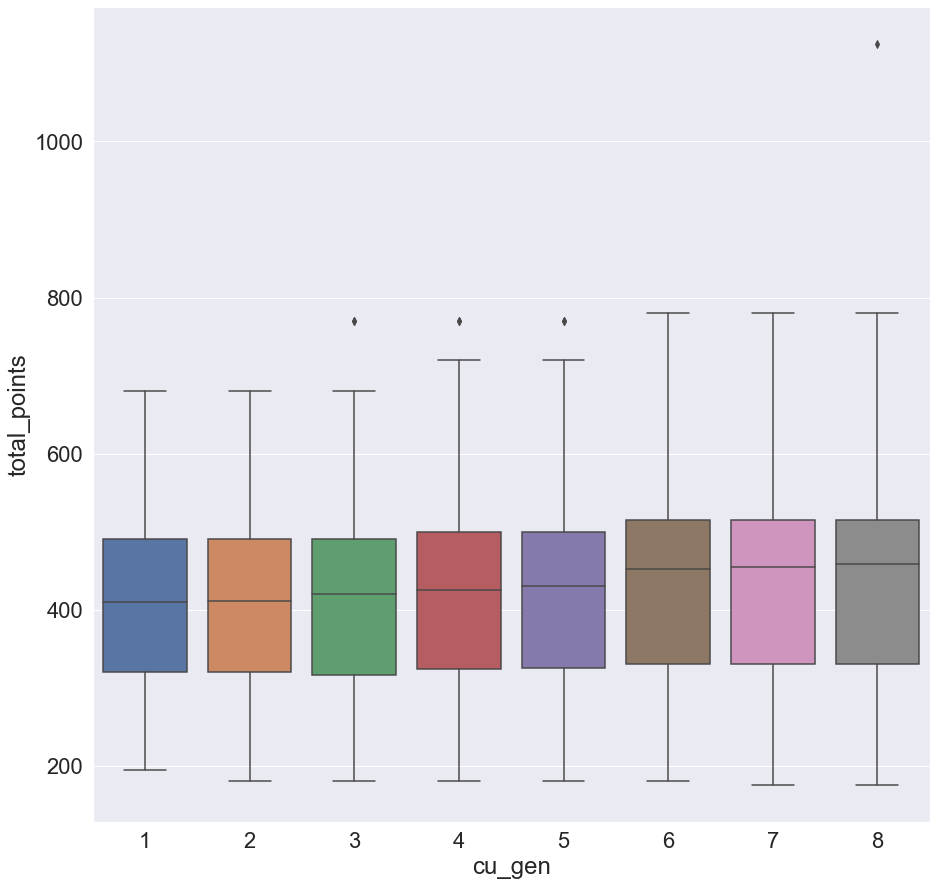

In [14]:
for i in range(0,len(cu_arr)):
    cu_arr[i]['cu_gen'] = [i+1] * len(cu_arr[i])
    
cu_frame = pd.concat(cu_arr)

plt.figure(figsize=(15,15))
sns.set(font_scale=2)
ax = sns.boxplot(x='cu_gen', y='total_points', data=cu_frame)
ax

Even with the Mega Evolutions in Generation 6, the average base stat total is very even across generations, meaning Game Freak does a very good job at balancing new Pokémon added in each generation. Since Mega Evolutions are included in generations 6 and above, and even Dynamax formes are included in generation 8, we should consider what this chart looks like when these Pokémon aren't included!

<AxesSubplot:xlabel='cu_gen', ylabel='total_points'>

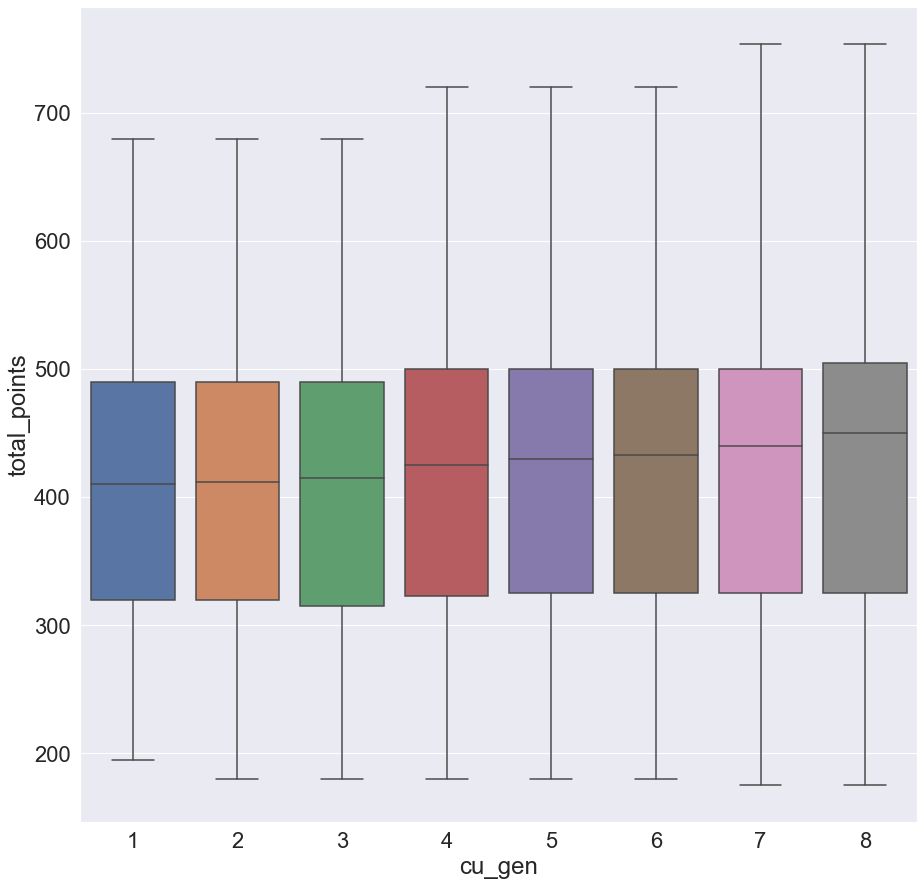

In [18]:
no_mega_cu = []

for i in range(1,9):
    tempframe = no_megas[no_megas['generation'] <= i].copy()
    no_mega_cu.append(tempframe)
    
for i in range(0,len(no_mega_cu)):
    no_mega_cu[i]['cu_gen'] = [i+1] * len(no_mega_cu[i])
    
no_mega_frame = pd.concat(no_mega_cu)

plt.figure(figsize=(15,15))
sns.set(font_scale=2)
ax = sns.boxplot(x='cu_gen', y='total_points', data=no_mega_frame)
ax

As we can see from the chart above, with each added base Pokémon (no Mega/Dynamax formes), the average base stat total in each generation does not change, and with numerical data...

In [25]:
gen_1 = no_mega_cu[0]['total_points'].mean()
gen_8 = no_mega_cu[len(no_mega_cu)-1]['total_points'].mean()

print('Average base stat total, gen 1: {}\tAverage base stat total, gen 8: {}'.format(gen_1, gen_8))
print('Difference between gen 8 and gen 1: {}'.format(gen_8-gen_1))

Average base stat total, gen 1: 407.9673202614379	Average base stat total, gen 8: 429.2870090634441
Difference between gen 8 and gen 1: 21.31968880200617


The average base stat total from all Pokémon in generation 1 to all Pokémon in generation 8 (which in this case is actually all Pokémon ever) is just above 20, meaning that a team containing purely generation 1 Pokémon against a team containing Pokémon from all generation would, theoretically, be on a level playing field, and I'll be looking into that in Step 4.

### Step 3.C: Types

Throughout the generations, dragon types have had a reputation of being the most powerful Pokémon, with many of the pseudolegendary Pokémon (Non-legendary Pokémon with >=600 base stat total) being dragon types, with the only exceptions being Slaking, Tyranitar, and Metagross. So I wanted to compare the different types that include all Pokémon from all generations, and see if that claim still holds true.

<AxesSubplot:xlabel='type', ylabel='total_points'>

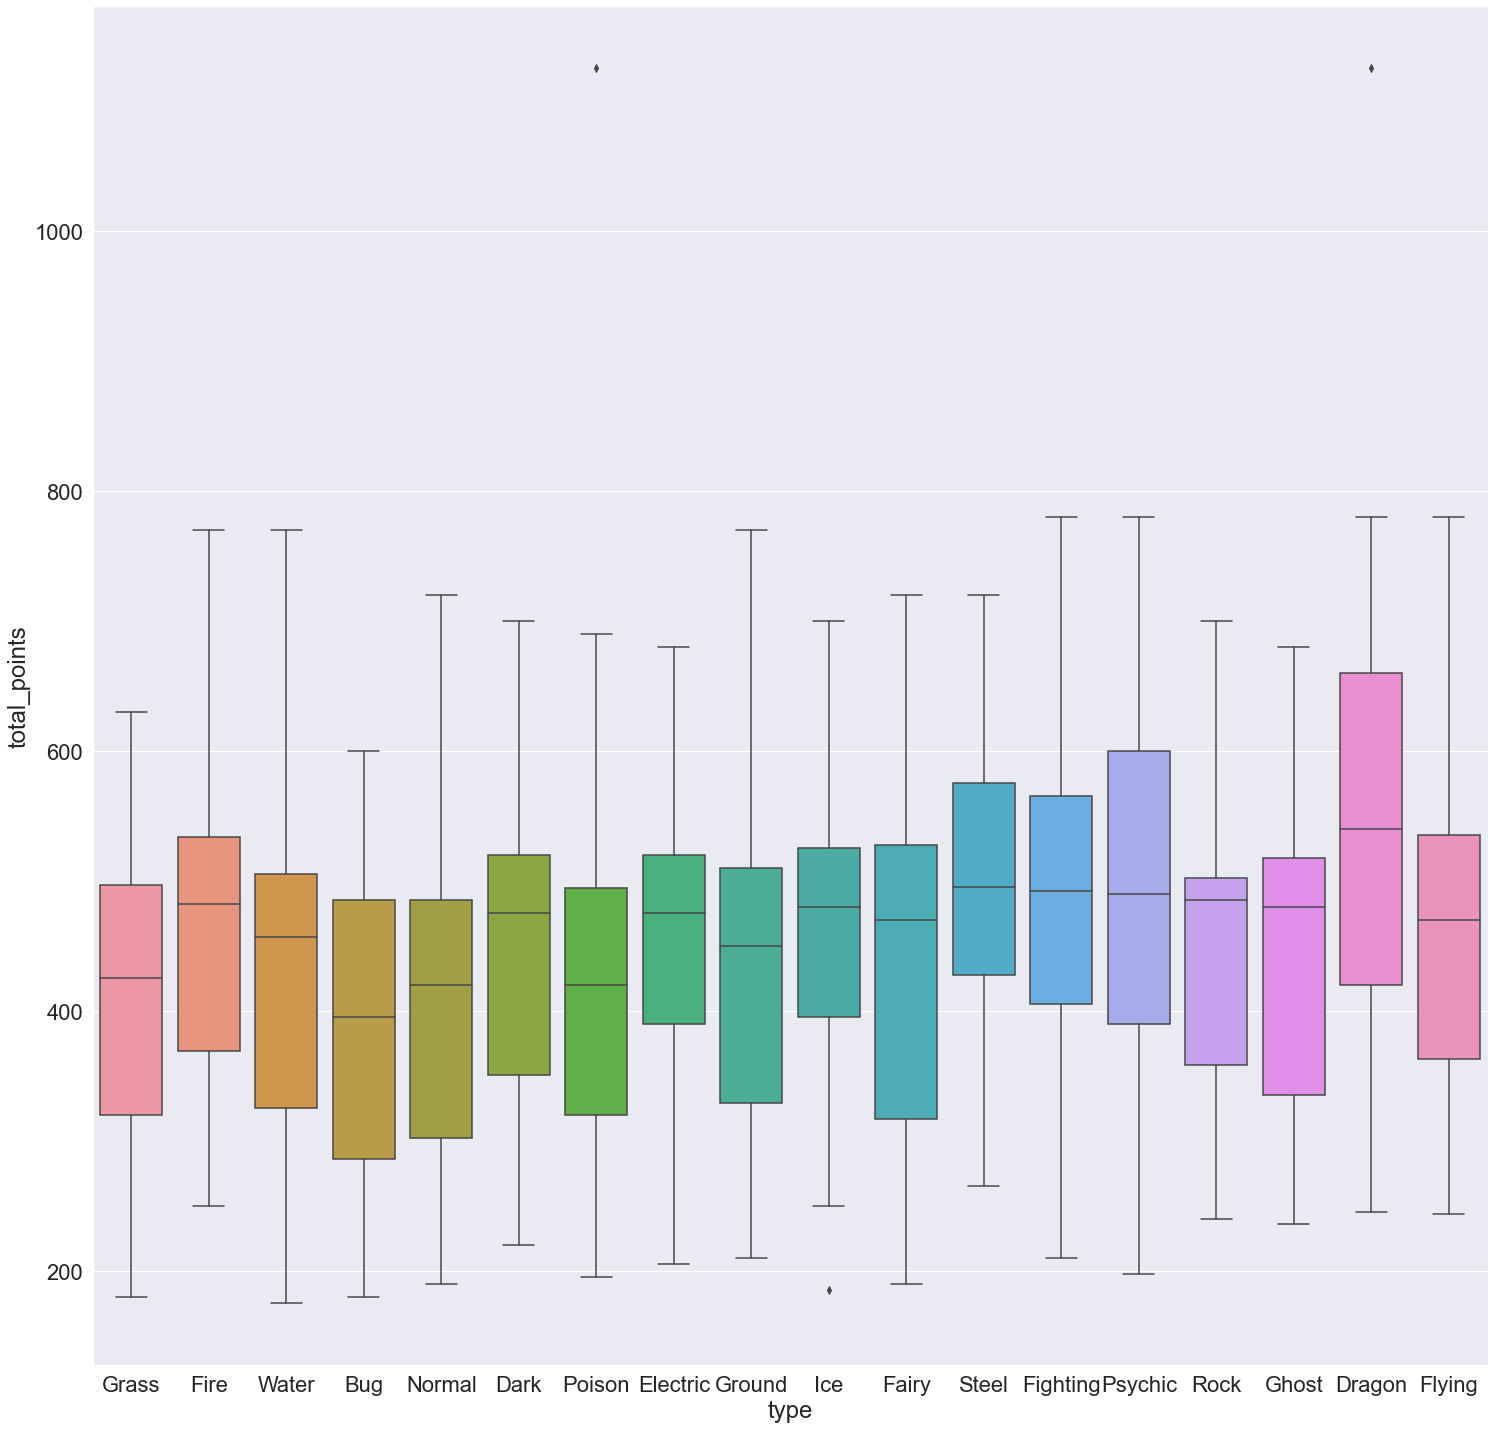

In [6]:
plt.figure(figsize=(25,25))
sns.set(font_scale=2)
type_frame = pd.concat(type_arr)
ax = sns.boxplot(x='type', y='total_points', data = type_frame)
ax

Obviously, Dragon type still holds a massive lead over the other types in Pokémon, but Dragon type also includes Eternatus Eternamax Forme, which has a base stat total of 1125, the only Pokémon with over 1000 base stat total. It is also included in Poison type, because Eternatus is Poison-Dragon dual type, but it's obvious that Poison is still a weaker type. In addition, Mega Evolutions are counted towards these stat totals, so does removing the Dynamax Pokémon and Mega Evolutions change anything this time?

<AxesSubplot:xlabel='type', ylabel='total_points'>

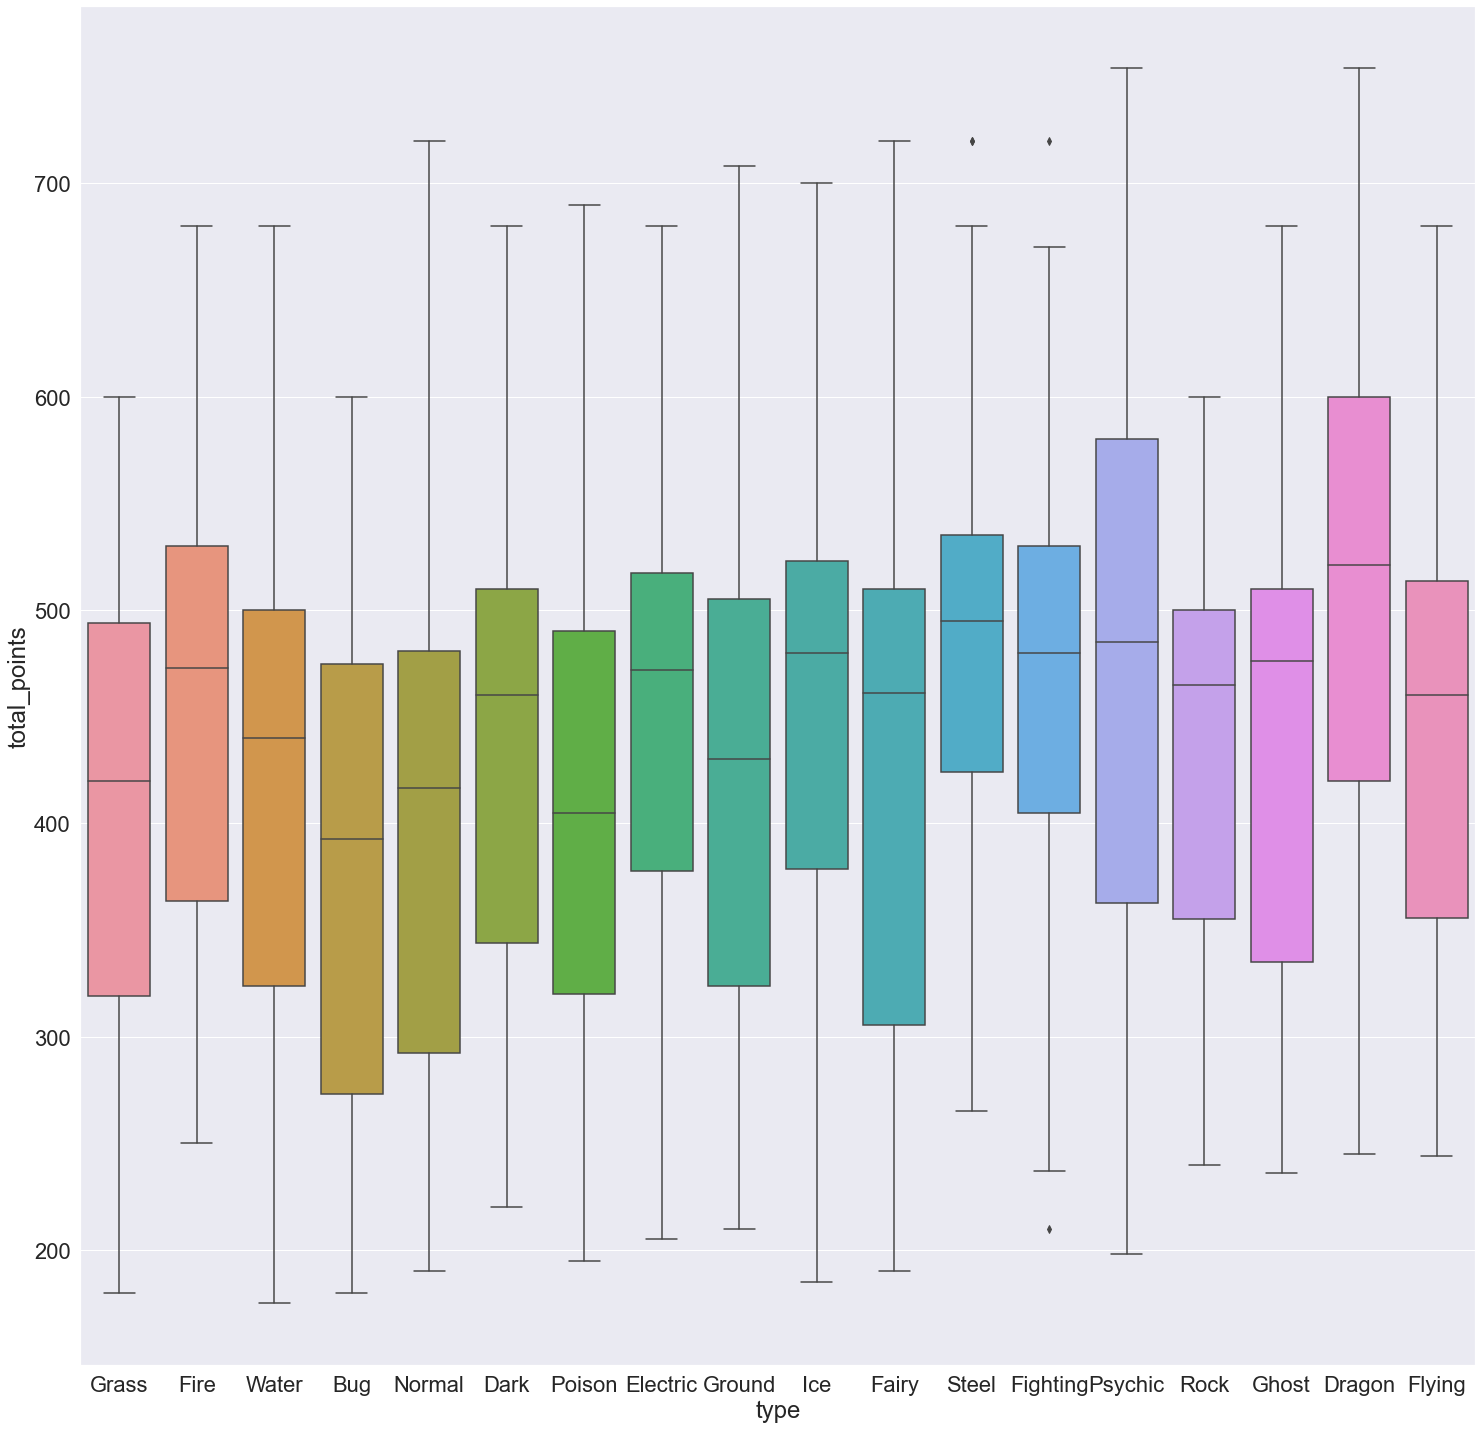

In [7]:
type_no_megas = []
for color in types:
    tempframe1 = no_megas[(no_megas['type_1'] == color) | (no_megas['type_2'] == color)].copy()
    tempframe1['type'] = [color] * len(tempframe1)
    type_no_megas.append(tempframe1)
    
plt.figure(figsize=(25,25))
sns.set(font_scale=2)
type_frame_no = pd.concat(type_no_megas)
ax = sns.boxplot(x='type', y='total_points', data = type_frame_no)
ax

It seems like removing Dynamax and Mega Evolutions doesn't change much. Dragon type still has a significant lead in base stat total, albeit the lead is smaller with the removal, and it is the only type with over 500 average base stat total. This makes sense, because typically Dragon type Pokémon are legendaries, or they can only be caught at a much later point in the games, meaning they would be more powerful Pokémon than the Bug types you can catch on the first route.

### Step 3.D: Pokémon Categories

If you didn't know already, there are these Pokémon called **Legendary Pokémon**, and they're the ones on the covers of all the games (other than Red/Green/Blue/Yellow and their remakes), and they're typically significantly stronger than most fully evolved Pokémon, and they are very viable on your team. There are actually three types of legendaries: **Sub-Legendary**, which are legendaries allowed in competitive battles typically without restriction, and they're usually not the ones on the covers; **Legendary**, which are the ones on the covers of the games, and are typically not allowed in competitive battles; and **Mythical**, which are not obtainable in-game, but rather through real-life events, and are also not allowed in competitive battles.

What I want to determine with these Pokémon is if they really are that much stronger than all of the other Pokémon, and later we can determine if an average team of 6 regular Pokémon can beat an average team of all types of legendaries. For now, let's take a look at the base stat total distribution of all the categories of Pokémon.

<AxesSubplot:xlabel='status', ylabel='total_points'>

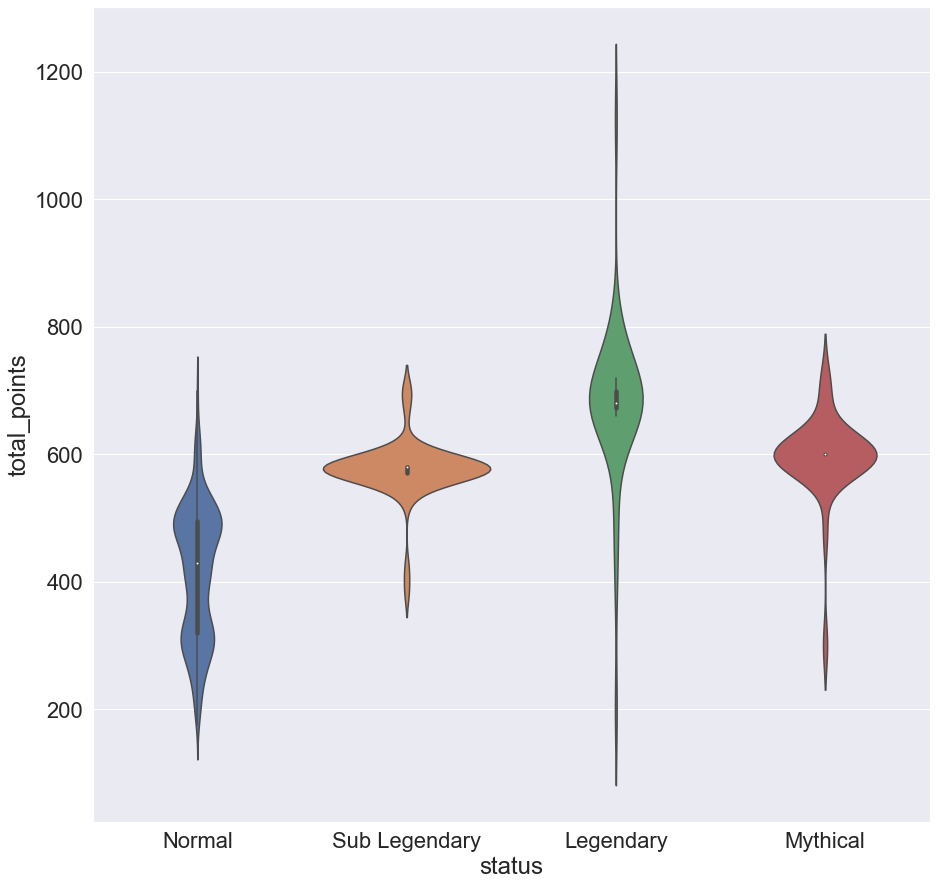

In [30]:
plt.figure(figsize=(15,15))
sns.set(font_scale=2)
ax = sns.violinplot(x='status', y='total_points', data=data)
ax

There aren't many Pokémon of any Legendary category, so a box plot would just look like a bunch of dots on a line, which doesn't look good. Besides that, we can see that Legendaries do live up to their name, with their averages well above the Normal Pokémon. But, of course, the legendaries include Eternatus Eternamax, and even some legendaries have Mega Evolutions as well and Normal Pokémon, so do the base formes of all Pokémon look similar?

<AxesSubplot:xlabel='status', ylabel='total_points'>

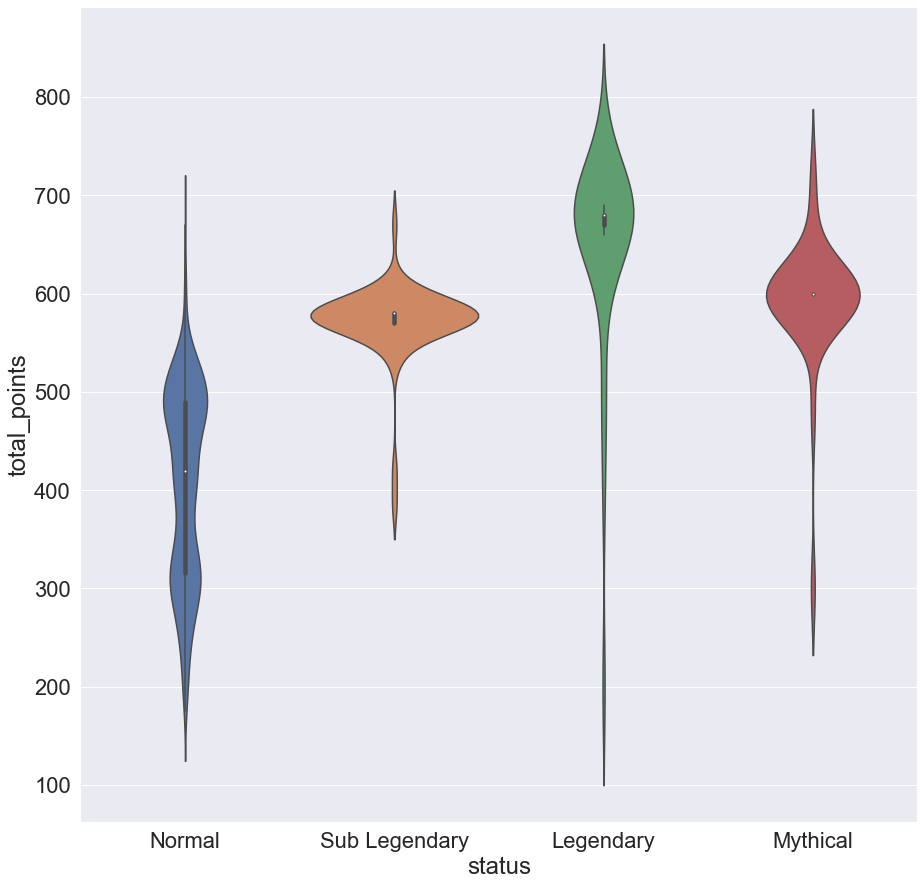

In [31]:
plt.figure(figsize=(15,15))
sns.set(font_scale=2)
ax = sns.violinplot(x='status', y='total_points', data=no_megas)
ax

Turns out that removing super powerful formes of all Pokémon still doesn't make the Legendaries any weaker, as its obvious the average base stat total of each Legendary category is higher than the average base stat total of every other Pokémon. Additionally, the reason why Legendary Pokémon stats can get so low is because in generation 7, they introduced evolving legendaries, so just like other Pokémon that can evolve, the first stage Pokémon is typically weaker than the rest.

For example, Cosmog, introduced in generation 7, has a base stat total of only 200, but it is still classified as a legendary. However, it evolves into Cosmoem, with a base stat total of 400. From there, Cosmoem can either evolve into Solgaleo or Lunala, both of which have a base stat total of 680.

In [33]:
for i in range(0,len(class_arr)):
    print('Average base stat total for cat {}: {}'.format(i, class_arr[i]['total_points'].mean()))

Average base stat total for cat 0: 415.2636165577342
Average base stat total for cat 1: 576.5272727272727
Average base stat total for cat 2: 675.3095238095239
Average base stat total for cat 3: 594.6666666666666


For the above, categories 0-3 relate to the graph above, with cat 0 being Normal Pokémon, 1 relating to Sub Legendaries, 2 relating to Legendaries, and 3 relating to Mythicals.

## Step 4: Drawing statistics and models on the data

Now we're going into the big stuff! This is the part where we start taking samples from generations and types, and from those we create a distribution to help determine the average power of a team of 6 Pokémon from each sample, and using ANOVA, we can determine if there is a significant difference between the averages of each category. We'll consider exclusive generations, cumulative generations, specific types, and the specification of the Pokémon.

### Step 4.A: Unique Generations

I will be making every generation a normal distribution, because the number of Pokémon in each generation is significant enough that I can safely assume that the distribution of the base stat totals are normal. From there, I will be taking 60 random samples (effectively simulating 10 random teams) from each generation and performing ANOVA with the combination of eah generational sample with a significance of 0.05.

In [225]:
gen_anova = []
np.random.seed(3)

for i in range(0, len(gen_arr)):
    gen_anova.append(np.random.normal(loc = gen_arr[i]['total_points'].mean(), scale = gen_arr[i]['total_points'].std(), size = 60))
    print("Average base stat total of sample of size 60 for generation {}: {}".format(i+1, float(sum(gen_anova[i]))/len(gen_anova[i])))


stat.f_oneway(gen_anova[0], gen_anova[1], gen_anova[2], gen_anova[3], gen_anova[4], gen_anova[5], gen_anova[6], gen_anova[7])

Average base stat total of sample of size 60 for generation 1: 385.19457932933454
Average base stat total of sample of size 60 for generation 2: 415.9085145342378
Average base stat total of sample of size 60 for generation 3: 400.41167330478515
Average base stat total of sample of size 60 for generation 4: 469.42523756413794
Average base stat total of sample of size 60 for generation 5: 467.3592343293208
Average base stat total of sample of size 60 for generation 6: 479.274432360677
Average base stat total of sample of size 60 for generation 7: 450.70762438388107
Average base stat total of sample of size 60 for generation 8: 450.9494554861428


F_onewayResult(statistic=5.068777039588145, pvalue=1.4552348239296871e-05)

Because the P-value is smaller than the level of significance, we can tell that there is a significant difference in the average base stat total of both 10 generational teams and 60 generational Pokémon from each generation, and I expected this to happen. Generation 6 has Mega Evolutions, and generation 4 has the highest average base-forme Pokémon, meaning that those two generations should have a higher average than generations 1, 2, and 3, the three weakest generations.

But what happens if we take out those mega evolutions and run another ANOVA test at 0.05 significance?

In [223]:
no_cu_arr = []
no_gen_arr = []

for i in range(1,9):
    tempframe = data[data['generation'] <= i].copy()
    no_cu_arr.append(tempframe)
    subframe = data[data['generation'] == i]
    no_gen_arr.append(subframe)
    
no_gen_anova = []
np.random.seed(3)

for i in range(0, len(no_gen_arr)):
    no_gen_anova.append(np.random.normal(loc = no_gen_arr[i]['total_points'].mean(), scale = no_gen_arr[i]['total_points'].std(), size = 60))
    print("Average base stat total of sample of size 60 for generation {} with no Mega Evolutions: {}".format(i+1, float(sum(no_gen_anova[i]))/len(no_gen_anova[i])))

stat.f_oneway(no_gen_anova[0], no_gen_anova[1], no_gen_anova[2], no_gen_anova[3], no_gen_anova[4], no_gen_anova[5], no_gen_anova[6], no_gen_anova[7])

Average base stat total of sample of size 60 for generation 1 with no Mega Evolutions: 398.2971909650358
Average base stat total of sample of size 60 for generation 2 with no Mega Evolutions: 429.69477072697543
Average base stat total of sample of size 60 for generation 3 with no Mega Evolutions: 426.9292933403107
Average base stat total of sample of size 60 for generation 4 with no Mega Evolutions: 476.94181551858946
Average base stat total of sample of size 60 for generation 5 with no Mega Evolutions: 467.5247203318609
Average base stat total of sample of size 60 for generation 6 with no Mega Evolutions: 416.97389115995156
Average base stat total of sample of size 60 for generation 7 with no Mega Evolutions: 460.78794089096533
Average base stat total of sample of size 60 for generation 8 with no Mega Evolutions: 456.6612363281545


F_onewayResult(statistic=3.0408613387039782, pvalue=0.0038755858342812586)

Even without Mega Evoutions, there is significant evidence that there is still a difference in the average base stat totals of each generation. Obviously, a team of Pokémon from an exclusive older generation is going to struggle against a team of Pokémon from an exclusive newer generation.

### Step 4.B: Combined Generations

Similar to 3.B, in each generation, we aren't limited to just the Pokémon introduced in each generation; we can use Pokémon from previous generations too. Using the same test as before, let's find out if there is a significant difference between each combined generation.

In [224]:
com_anova = []
np.random.seed(3)

for i in range(0, len(cu_arr)):
    com_anova.append(np.random.normal(loc = cu_arr[i]['total_points'].mean(), scale = cu_arr[i]['total_points'].std(), size = 60))
    print("Average base stat total of sample of size 60 for combined generation {}: {}".format(i+1, float(sum(com_anova[i]))/len(com_anova[i])))
    
stat.f_oneway(com_anova[0], com_anova[1], com_anova[2], com_anova[3], com_anova[4], com_anova[5], com_anova[6], com_anova[7])

Average base stat total of sample of size 60 for combined generation 1: 385.19457932933454
Average base stat total of sample of size 60 for combined generation 2: 416.40357637616603
Average base stat total of sample of size 60 for combined generation 3: 400.25837700448454
Average base stat total of sample of size 60 for combined generation 4: 434.4834530790521
Average base stat total of sample of size 60 for combined generation 5: 455.3530086223691
Average base stat total of sample of size 60 for combined generation 6: 410.5009857088285
Average base stat total of sample of size 60 for combined generation 7: 439.46857905642304
Average base stat total of sample of size 60 for combined generation 8: 439.9862768390354


F_onewayResult(statistic=2.562031132556818, pvalue=0.013426139026532107)

With a significance level of 0.05, there is significant evidence that there is a difference when combining generations together, but the data is almost not significant enough. As we combine more and more generations, the average base stat total starts to level out and remain constant, meaning that the difference in average base stat total becomes less and less as more Pokémon games come out. There is still a big difference between generation 1 and generation 8, but there is virtually none between generations 7 and 8.

### Step 4.C: Types

Same as before, except I'm going to compare the different types against each other with an ANOVA test at 0.05 significance. I don't expect there to be a huge difference across ALL of the types. Game Freak does a decent job keeping the types smoothly balanced, and there isn't one type to completely rely on.

In [253]:
type_anova = []
np.random.seed(3)
total = 0
for i in range(0, len(type_arr)):
    type_anova.append(np.random.normal(loc = type_arr[i]['total_points'].mean(), scale = type_arr[i]['total_points'].std(), size = 60))
    print("Average base stat total of sample size 60 of type {}: {}".format(type_arr[i]['type'].unique(), float(sum(type_anova[i]))/len(type_anova[i])))
    total = total + float(sum(type_anova[i]))/len(type_anova[i])
    
stat.f_oneway(type_anova[0], type_anova[1], type_anova[2], type_anova[3], type_anova[4], type_anova[5], type_anova[6], type_anova[7], type_anova[8], type_anova[9], type_anova[10], type_anova[11], type_anova[12], type_anova[13], type_anova[14], type_anova[15], type_anova[16], type_anova[17])

Average base stat total of sample size 60 of type ['Grass']: 394.87583953572397
Average base stat total of sample size 60 of type ['Fire']: 472.1979409180272
Average base stat total of sample size 60 of type ['Water']: 422.87310421261634
Average base stat total of sample size 60 of type ['Bug']: 401.7736256997146
Average base stat total of sample size 60 of type ['Normal']: 438.59869079939136
Average base stat total of sample size 60 of type ['Dark']: 428.3151505100996
Average base stat total of sample size 60 of type ['Poison']: 421.57278018839537
Average base stat total of sample size 60 of type ['Electric']: 449.93116025230796
Average base stat total of sample size 60 of type ['Ground']: 444.1425358374362
Average base stat total of sample size 60 of type ['Ice']: 463.89703905584355
Average base stat total of sample size 60 of type ['Fairy']: 461.5578032423759
Average base stat total of sample size 60 of type ['Steel']: 492.5199588229965
Average base stat total of sample size 60 of t

F_onewayResult(statistic=4.466364438575145, pvalue=4.6383648861078974e-09)

I was proven wrong! I was thinking too much about the bigger picture, rather than strictly comparing types against one another, and I guess there is a huge difference between Grass type and Dragon type on average. There is indeed significant evidence that there is a difference in the average base stat totals of the Pokémon types.

But if you consider a team of any type of 6 Pokémon...

In [252]:
np.random.seed(3)

#Using n=60*18 because the average of the average of each type has 60*18 samples, so it should only be the same for any 6 Pokémon as well
full_team = np.random.normal(loc = data['total_points'].mean(), scale = data['total_points'].std(), size = 60*18)
print('Average base stat total of all Pokémon: {}\nAverage base stat total of a team of a specific type: {}'.format(float(sum(full_team))/len(full_team), float(total)/len(type_arr)))

Average base stat total of all Pokémon: 441.1071965715444
Average base stat total of a team of a specific type: 452.75001161583464


There is a small difference in the two averages, but not enough that there would be a significant difference in the results of a battle between any 6 Pokémon and 6 Pokémon of a certain type.

### Step 4.C: Pokémon Categories

This is the one I'm personally most excited for. You can compare generations all you want, and compare between types, and while that helps for setting up teams and deciding what Pokémon to keep and what Pokémon to evolve, in the end, many trainers will end up with a diverse team of many different types. Most people will probably end up with only Normal Pokémon - no legendaries or anything. Some people might make a team of *only* Legendaries. So now I will once again perform an ANOVA test at 0.05 significance. I will be expecting a difference, because legendaries are very strong compared to normal Pokémon, but I will also be comparing Normal vs Sub-Legendary, because those two categories are allowed in competitive battles, and Legendary vs Mythical, because it'll be interesting if there is a difference in the box art legendaries and the exclusive, real-life event Pokémon.

In [266]:
cat_anova = []
np.random.seed(3)

for i in range(0,len(class_arr)):
    cat_anova.append(np.random.normal(loc = class_arr[i]['total_points'].mean(), scale = class_arr[i]['total_points'].std(), size = 60))
    print("Average base stat total of sample of size 60 for category {}: {}".format(class_arr[i]['status'].unique(), float(sum(cat_anova[i]))/len(cat_anova[i])))
    
stat.f_oneway(cat_anova[0], cat_anova[1], cat_anova[2], cat_anova[3])

Average base stat total of sample of size 60 for category ['Normal']: 391.28418266223605
Average base stat total of sample of size 60 for category ['Sub Legendary']: 580.4953362753848
Average base stat total of sample of size 60 for category ['Legendary']: 666.8723418521131
Average base stat total of sample of size 60 for category ['Mythical']: 604.9018691391874


F_onewayResult(statistic=108.25412930301628, pvalue=4.170563594761469e-44)

This feels redundant, but there certainly is enough evidence that there is a significant difference in the average base stat total of all of the categories of Pokémon at a 0.05 significance level.

From this, I can tell that there is going to be a significant difference between Normal and Sub Legendary, but I do want to take more samples with a different seed of all 4 categories before I compare Normal and Sub-Legendary, and Legendary and Mythical. After that, I will run a 2-sample T test on Normal vs Sub-Legendary average base stat totals, and another one on Legendary vs Mythical average base stat totals.

In [272]:
battle_ready = []
no_battle = []
np.random.seed(15)

battle_ready.append(np.random.normal(loc = class_arr[0]['total_points'].mean(), scale = class_arr[0]['total_points'].std(), size = 60))
battle_ready.append(np.random.normal(loc = class_arr[1]['total_points'].mean(), scale = class_arr[1]['total_points'].std(), size = 60))
no_battle.append(np.random.normal(loc = class_arr[2]['total_points'].mean(), scale = class_arr[2]['total_points'].std(), size = 60))
no_battle.append(np.random.normal(loc = class_arr[3]['total_points'].mean(), scale = class_arr[3]['total_points'].std(), size = 60))

print('Normal vs Sub-Legendary:', stat.ttest_ind(battle_ready[0], battle_ready[1]))
print('Legendary vs Mythical: ', stat.ttest_ind(no_battle[0], no_battle[1]))

Normal vs Sub-Legendary: Ttest_indResult(statistic=-11.228204641092187, pvalue=2.413354817025989e-20)
Legendary vs Mythical:  Ttest_indResult(statistic=2.840168936710747, pvalue=0.005312145264391707)


Turns out in both cases, there is significant differences between Normal vs Sub-Legendary, and Legendary vs Mythical, so if you ever want to become a competitive Pokémon trainer, it wouldn't hurt to put a few Sub-Legendary Pokémon on your team; and if competitive Pokémon isn't your thing, I would definitely recommend having a legendary on your team when it's your first time playing Pokémon!

### Step 5: Multiple Regression Analysis

When looking at the stats of Pokémon, you might think there is a trend between all of the stats, and you might be right. A high attack stat, but a low defense stat might mean that the speed stat is very high, or a high defense stat might also mean a high HP stat. I want to also test that. I'm planning on making 6 different regression analyses, one for each stat, and test them against the generation 1 fully evolved starter Pokémon to determine how accurate the regressions can be.

In [275]:
X_hp = dayta[['attack','sp_attack','defense','sp_defense','speed']]
y_hp = dayta['hp']
X_atk = dayta[['hp','sp_attack','defense','sp_defense','speed']]
y_atk = dayta['attack']
X_spa = dayta[['hp','attack','defense','sp_defense','speed']]
y_spa = dayta['sp_attack']
X_def = dayta[['hp','attack','sp_attack','sp_defense','speed']]
y_def = dayta['defense']
X_spf = dayta[['hp','attack','sp_attack','defense','speed']]
y_spf = dayta['sp_defense']
X_spd = dayta[['hp','attack','sp_attack','defense','sp_defense']]
y_spd = dayta['speed']

In [277]:
hp_reg = linear_model.LinearRegression()
atk_reg = linear_model.LinearRegression()
def_reg = linear_model.LinearRegression()
spa_reg = linear_model.LinearRegression()
spf_reg = linear_model.LinearRegression()
spd_reg = linear_model.LinearRegression()
hp_reg.fit(X_hp,y_hp);
atk_reg.fit(X_atk,y_atk);
def_reg.fit(X_def,y_def);
spa_reg.fit(X_spa,y_spa);
spf_reg.fit(X_spf,y_spf);
spd_reg.fit(X_spd,y_spd);

Venusaur:
 - HP: 80
 - ATK: 82
 - SPA: 100
 - DEF: 83
 - SPF: 100
 - SPD: 80

In [291]:
print('HP: {}'.format(hp_reg.predict([[82,100,83,100,80]])[0]))
print('ATK: {}'.format(atk_reg.predict([[80,100,83,100,80]])[0]))
print('SPA: {}'.format(spa_reg.predict([[80,82,83,100,80]])[0]))
print('DEF: {}'.format(def_reg.predict([[80,82,100,100,80]])[0]))
print('SPF: {}'.format(spf_reg.predict([[80,82,100,83,80]])[0]))
print('SPD: {}'.format(spd_reg.predict([[80,82,100,83,100]])[0]))

HP: 79.5300304770527
ATK: 87.72907538353705
SPA: 90.68803907745931
DEF: 86.28543798020925
SPF: 87.27872656207845
SPD: 78.64242997988873


-----------------------------------------------------------------------------------------------
Charizard:
 - HP: 78
 - ATK: 84
 - SPA: 109
 - DEF: 78
 - SPF: 85
 - SPD: 100

In [292]:
print('HP: {}'.format(hp_reg.predict([[84,109,78,85,100]])[0]))
print('ATK: {}'.format(atk_reg.predict([[78,109,78,85,100]])[0]))
print('SPA: {}'.format(spa_reg.predict([[78,84,78,85,100]])[0]))
print('DEF: {}'.format(def_reg.predict([[78,84,109,85,100]])[0]))
print('SPF: {}'.format(spf_reg.predict([[78,84,109,78,100]])[0]))
print('SPD: {}'.format(spd_reg.predict([[78,85,109,78,85]])[0]))

HP: 76.42823757115355
ATK: 96.79894025057546
SPA: 89.70614446290094
DEF: 72.39289787474958
SPF: 89.08322779040026
SPD: 81.47639708392983


-------------------------
Blastoise:
 - HP: 79
 - ATK: 83
 - SPA: 85
 - DEF: 100
 - SPF: 105
 - SPD: 78


In [293]:
print('HP: {}'.format(hp_reg.predict([[83,85,100,105,78]])[0]))
print('ATK: {}'.format(atk_reg.predict([[79,85,100,105,78]])[0]))
print('SPA: {}'.format(spa_reg.predict([[79,83,100,105,78]])[0]))
print('DEF: {}'.format(def_reg.predict([[79,83,85,105,78]])[0]))
print('SPF: {}'.format(spf_reg.predict([[79,83,95,100,78]])[0]))
print('SPD: {}'.format(spd_reg.predict([[79,83,85,100,105]])[0]))

HP: 78.85415792799196
ATK: 91.40576667290425
SPA: 90.5040806441229
DEF: 91.78829381310723
SPF: 92.93807345396539
SPD: 70.49896325142562


The multiple regression algorithms aren't entirely perfect, but that's because the designers at Game Freak hand pick the statistics for each Pokémon. There isn't a set algorithm for deiciding the stats of any Pokémon, but rather it's the collective knowledge of the designers at Game Freak. Regardless, using an algorithm like this is a good learning experience for how Pokémon are balanced, as well as expected values of Pokémon with certain stats.

### Step 6: Conclusion

I wanted to make this website to not only further my own knowledge of Pokémon as I get back in to what made so many childhoods special, but to possibly help anyone that is new to Pokémon learn the basics of Pokémon strengths, and hopefully this will help them create a team of their own when they start to play Pokémon.

We learned that there is a significant difference in how powerful Pokémon are between generations, as well as the combined generations. We learned that there are strong and weak types, but that only depends on the route you are catching Pokémon on. We've learned that Sub-Legendaries are great for late game, and Legendaries/Mythicals are incredibly powerful. I hope that the beginner Pokémon players out there may have learned something; I hope that the data scientists looking at this can be satisfied with the work I've done; and I hope everyone playing Pokémon has fun in the end. It's not meant to be a competition in Pokémon, even if there are competitive battles. To take a quote from Elite Four member Karen: "Strong Pokémon. Weak Pokémon. That is only the selfish perception of people. Truly skilled Trainers should try to win with the Pokémon they love best."